In [1]:
import os
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
import os
import sys
import json
from matplotlib.collections import LineCollection
import lmfit
import pickle

# from clustering_scripts import *

In [2]:
def folder_create(path):
    # check if folder exists
    if not os.path.exists(path):
        os.makedirs(path)
        print("Created folder: ", path)

In [3]:
def make_line_collection(data, amplitude, times, idx_skip=0, max_amplitude=None, min_amplitude=None):
    y = data[:,::idx_skip].copy()
    amp = amplitude[::idx_skip].copy()

    if max_amplitude is None:
        max_amplitude = np.max(amp)
    if min_amplitude is None:
        min_amplitude = np.min(amp)

    mask = (amp >= min_amplitude) & (amp <= max_amplitude)

    colormap = plt.cm.get_cmap("viridis")
    colors = [colormap(i) for i in (amp - min_amplitude) / (max_amplitude - min_amplitude)]

    # apply mask
    y[:, ~mask] = np.nan

    segs = np.zeros((len(y[0]), len(y), 2))
    segs[:,:,0] = times[:]
    segs[:,:,1] = y.T

    return segs, colors

In [4]:
DATADIR = "../data/"
FIGDIR = "../img/"

In [5]:
amplitude_choices = {
    "all": (None, None),
    "inner_core": (0, 5),
    "outer_core": (5, 10),
    "tail": (10, 15),
    "chaos": (15, None),
}

fig_name_list = [
    "worst_zeta_min",
    "worst_zeta_avg",
    # "worst_zeta_max",
    # "best_zeta_min",
    # "best_zeta_avg",
    # "best_zeta_max",
]

filenames_rem = [
    "rem_b1_worst_zeta_min.h5",
    "rem_b1_worst_zeta_avg.h5",
    # "rem_b1_worst_zeta_max.h5",
    # "rem_b1_best_zeta_min.h5",
    # "rem_b1_best_zeta_avg.h5",
    # "rem_b1_best_zeta_max.h5",
]

filenames_disp = [
    "log_displacement_b1_worst_zeta_min.h5",
    "log_displacement_b1_worst_zeta_avg.h5",
    # "log_displacement_b1_worst_zeta_max.h5",
    # "log_displacement_b1_best_zeta_min.h5",
    # "log_displacement_b1_best_zeta_avg.h5",
    # "log_displacement_b1_best_zeta_max.h5",
]

filenames_stab = [
    "stability_b1_worst_zeta_min.h5",
    "stability_b1_worst_zeta_avg.h5",
    # "stability_b1_worst_zeta_max.h5",
    # "stability_b1_best_zeta_min.h5",
    # "stability_b1_best_zeta_avg.h5",
    # "stability_b1_best_zeta_max.h5",
]

for name, f_rem, f_disp, f_stab in (zip(tqdm(fig_name_list), filenames_rem, filenames_disp, filenames_stab)):
    

    with h5py.File(os.path.join(DATADIR, f_rem), "r") as f:
        times = list(sorted([int(s) for s in f["reverse/x_norm"].keys()]))
        rem = np.array(
            [
                np.power(f[f"reverse/x_norm/{t}"][:] - f["reference/initial/x_norm"][:], 2) +
                np.power(f[f"reverse/y_norm/{t}"][:] - f["reference/initial/y_norm"][:], 2) +
                np.power(f[f"reverse/px_norm/{t}"][:] - f["reference/initial/px_norm"][:], 2) +
                np.power(f[f"reverse/py_norm/{t}"][:] - f["reference/initial/py_norm"][:], 2) +
                np.power(f[f"reverse/zeta_norm/{t}"][:] - f["reference/initial/zeta_norm"][:], 2) +
                np.power(f[f"reverse/pzeta_norm/{t}"][:] - f["reference/initial/pzeta_norm"][:], 2)
                for t in times
            ])

    with h5py.File(os.path.join(DATADIR, "log_displacement_b1_worst_zeta_avg.h5"), "r") as f:
        amplitude = np.sqrt(
            f["reference/initial/x_norm"][:]**2 + f["reference/initial/y_norm"][:]**2
        )

    for a_key, (amp_min, amp_max) in amplitude_choices.items():
        segs, colors = make_line_collection(np.log10(rem), amplitude, times, idx_skip=70, min_amplitude=amp_min, max_amplitude=amp_max)

        if amp_min is None:
            amp_min = 0
        if amp_max is None:
            amp_max = np.max(amplitude)

        fig, ax = plt.subplots()
        ax.set_xlim(np.nanmin(segs[:,:,0]), np.nanmax(segs[:,:,0]))
        ax.set_ylim(np.nanmin(segs[:,:,1]), np.nanmax(segs[:,:,1])+0.1)

        line_segments = LineCollection(segs, alpha=0.5, linewidths=(1,),
                                        colors=colors, linestyle='solid')
        ax.add_collection(line_segments)
        ax.set_title(f'REM ' + a_key)
        ax.set_xscale("log")
        # add custom colorbar for the amplitude with values from amp_min to amp_max
        # https://stackoverflow.com/questions/53106501/matplotlib-colorbar-with-customized-range
        cmap = mpl.cm.get_cmap('viridis')
        norm = mpl.colors.Normalize(vmin=amp_min, vmax=amp_max)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm)

        folder_create(os.path.join(FIGDIR, f"rem/{a_key}"))

        fig.savefig(os.path.join(FIGDIR, f"rem/{a_key}/{f_rem}_{a_key}.jpg"), dpi=300)
        # close figure
        plt.close('all')

        fig, ax = plt.subplots()
        ax.set_xlim(np.nanmin(segs[:,:,0]), np.nanmax(segs[:,:,0]))
        ax.set_ylim(np.nanmin(segs[:,:,1]), np.nanmax(segs[:,:,1])+0.1)

        line_segments = LineCollection(segs, alpha=0.5, linewidths=(1,),
                                        colors=colors, linestyle='solid')
        ax.add_collection(line_segments)
        ax.set_title(f'REM ' + a_key)
        # ax.set_xscale("log")
        # add custom colorbar for the amplitude with values from amp_min to amp_max
        # https://stackoverflow.com/questions/53106501/matplotlib-colorbar-with-customized-range
        cmap = mpl.cm.get_cmap('viridis')
        norm = mpl.colors.Normalize(vmin=amp_min, vmax=amp_max)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar = plt.colorbar(sm)

        folder_create(os.path.join(FIGDIR, f"rem/{a_key}"))

        fig.savefig(os.path.join(FIGDIR, f"rem/{a_key}/{f_rem}_{a_key}_linear.jpg"), dpi=300)
        # close figure
        plt.close('all')

  0%|          | 0/2 [00:00<?, ?it/s]

/tmp/ipykernel_19471/3885548316.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap("viridis")
/tmp/ipykernel_19471/4124064925.py:85: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('viridis')
/tmp/ipykernel_19471/4124064925.py:89: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)
/tmp/ipykernel_19471/4124064925.py:108: MatplotlibDeprecationWarning:

In [6]:
f = h5py.File(os.path.join(DATADIR, "rem_b1_worst_zeta_avg.h5"), "r")


In [7]:
f["reference/"].keys()

<KeysViewHDF5 ['initial']>

In [8]:
with h5py.File(os.path.join(DATADIR, "rem_b1_worst_zeta_max.h5"), "r") as f:
    times = list(sorted([int(s) for s in f["reverse/x_norm"].keys()]))
    rem = np.array(
        [
            np.power(f[f"reverse/x_norm/{t}"][:] - f["reference/initial/x_norm"][:], 2) +
            np.power(f[f"reverse/y_norm/{t}"][:] - f["reference/initial/y_norm"][:], 2) +
            np.power(f[f"reverse/px_norm/{t}"][:] - f["reference/initial/px_norm"][:], 2) +
            np.power(f[f"reverse/py_norm/{t}"][:] - f["reference/initial/py_norm"][:], 2) +
            np.power(f[f"reverse/zeta_norm/{t}"][:] - f["reference/initial/zeta_norm"][:], 2) +
            np.power(f[f"reverse/pzeta_norm/{t}"][:] - f["reference/initial/pzeta_norm"][:], 2)
            for t in times
        ])
    
with h5py.File(os.path.join(DATADIR, "log_displacement_b1_worst_zeta_max.h5"), "r") as f:
    amplitude = np.sqrt(
        f["reference/initial/x_norm"][:]**2 + f["reference/initial/y_norm"][:]**2
    )

with h5py.File(os.path.join(DATADIR, "stability_b1_worst_zeta_max.h5"), "r") as f:
    stability = f["stability"][:]

In [9]:
final_rem = np.zeros_like(rem[-1]) * np.nan

for i in range(len(final_rem)):
    # for each particle, find the last rem value that is not nan
    # and set the final_rem value to that
    try:
        final_rem[i] = rem[np.where(~np.isnan(rem[:,i]))[0][-1], i]
    except IndexError:
        final_rem[i] = np.nan

clean_final_rem = final_rem.copy()[stability <= 1e5]
clean_stability = stability.copy()[stability <= 1e5]

In [10]:
def power_fit(params, x, data=None):
    a = params["a"].value
    b = params["b"].value
    c = params["c"].value

    model = a + b*np.log10(x)
    model[model > c] = c

    if data is None:
        return 10**model
    
    return model - np.log10(data)


def exp_fit(params, x, data=None):
    a = params["a"].value
    b = params["b"].value
    c = params["c"].value

    model = a + (b * x)
    model[model > c] = c

    if data is None:
        return 10**model
    
    return model - np.log10(data)

Text(0, 0.5, '$y_0 [\\sigma$ units$]$')

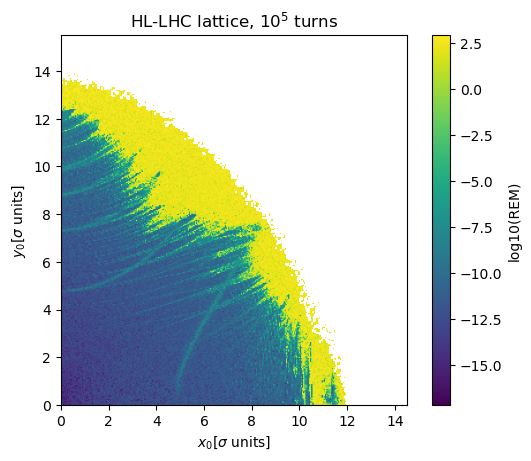

In [11]:
plt.imshow(np.log10(rem[-1]).reshape(300, 300), origin="lower",extent=[0.0,14.5,0,15.5])
plt.title("HL-LHC lattice, $10^5$ turns")
plt.colorbar(label="log10(REM)")
plt.xlabel("$x_0 [\\sigma$ units$]$")
plt.ylabel("$y_0 [\\sigma$ units$]$")

In [9]:
plt.imshow(np.log10(clean_final_rem).reshape(300, 300), origin="lower")
plt.colorbar()

ValueError: cannot reshape array of size 41607 into shape (300,300)

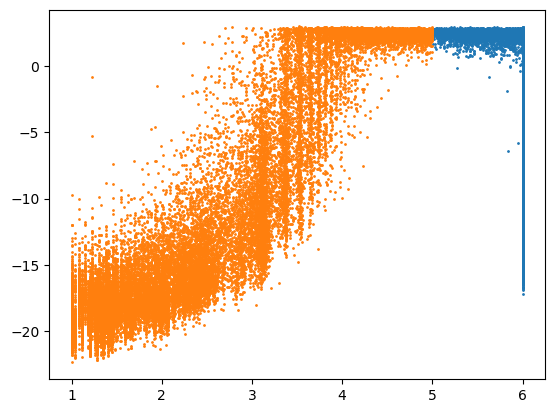

In [ ]:
plt.scatter(np.log10(stability), np.log10(rem[-1]), s=1)
plt.scatter(np.log10(clean_stability), np.log10(clean_final_rem), s=1)

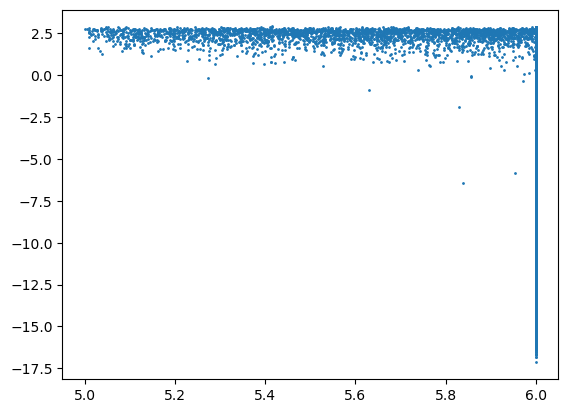

In [ ]:
plt.scatter(np.log10(stability), np.log10(rem[-1]), s=1)

In [12]:
idx_available = np.where(np.log10(rem[-1]) < -12)[0]
idx_regular = idx_available[np.random.randint(0, len(idx_available))]

In [13]:
idx_available = np.where(np.log10(rem[-1]) > 0)[0]
idx_chaos = idx_available[np.random.randint(0, len(idx_available))]

Text(0, 0.5, 'REM')

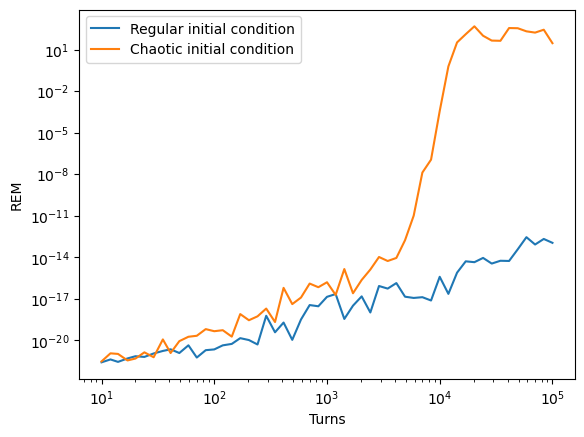

In [15]:
plt.plot(times, (rem[:, idx_regular]), label="Regular initial condition")
plt.plot(times, (rem[:, idx_chaos]), label="Chaotic initial condition")

plt.legend()

plt.yscale("log")
plt.xscale("log")

plt.xlabel("Turns")
plt.ylabel("REM")

In [38]:
out_power = []
out_exp = []

for i in [idx_regular, idx_chaos]:

    y = rem[20:,i]
    mask = (~np.isnan(y)) & (np.isfinite(y))
    x = np.asarray(times[20:])[mask]

    
    y = y[mask]
    y /= rem[0, i]

    lmfit_params = lmfit.Parameters()
    lmfit_params.add("a", value=1, min=0)
    lmfit_params.add("b", value=1)
    lmfit_params.add("c", value=23.38413861926543, vary=False)

    lmfit_out_power = lmfit.minimize(power_fit, lmfit_params, args=(x, y))

    lmfit_params = lmfit.Parameters()
    lmfit_params.add("a", value=1, min=0)
    lmfit_params.add("b", value=0.001)
    lmfit_params.add("c", value=23.38413861926543, vary=False)

    lmfit_out_exp = lmfit.minimize(exp_fit, lmfit_params, args=(x, y))

    out_power.append(lmfit_out_power)
    out_exp.append(lmfit_out_exp)


In [39]:
out_power

In [40]:
out_exp

# print the c values
for i in range(2):
    print(out_power[i].params["c"].value, out_exp[i].params["c"].value)

23.38413861926543 23.38413861926543
23.38413861926543 23.38413861926543


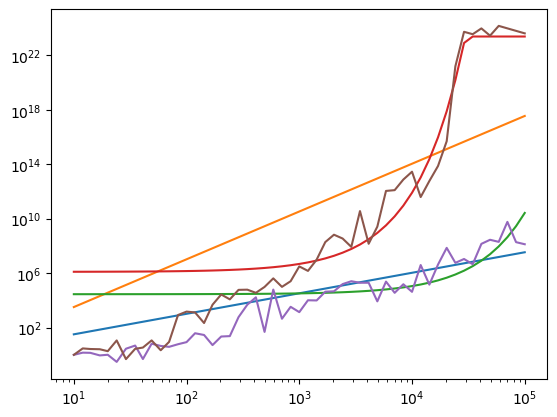

In [41]:
# plot the fits
plt.plot(times, power_fit(out_power[0].params, times), label="Power law")
plt.plot(times, power_fit(out_power[1].params, times), label="Power law")
plt.plot(times, exp_fit(out_exp[0].params, np.asarray(times)), label="Exponential")
plt.plot(times, exp_fit(out_exp[1].params, np.asarray(times)), label="Exponential")

for i in [idx_regular, idx_chaos]:

    y = rem[:,i]
    mask = (~np.isnan(y)) & (np.isfinite(y))
    x = np.asarray(times)[mask]
    y = y[mask]
    y /= y[0]
    plt.plot(x, y, label="Particle {}".format(i))

plt.xscale("log")
plt.yscale("log")

In [13]:
out_power = []
out_exp = []

for i in tqdm(range(len(rem[-1]))):
    if np.all(np.isnan(rem[:,i])):
        out_power.append([np.nan, np.nan, np.nan])
        out_exp.append([np.nan, np.nan, np.nan])
        continue
    
    y = rem[20:,i]
    mask = (~np.isnan(y)) & (np.isfinite(y))
    x = np.asarray(times[20:])[mask]
    y = y[mask]
    y /= rem[0, i]

    if np.all(np.isnan(y)) or len(y) < 2:
        out_power.append([np.nan, np.nan, np.nan])
        out_exp.append([np.nan, np.nan, np.nan])
        continue

    lmfit_params = lmfit.Parameters()
    lmfit_params.add("a", value=1)
    lmfit_params.add("b", value=1)
    lmfit_params.add("c", value=23.38413861926543, vary=False)

    lmfit_out_power = lmfit.minimize(power_fit, lmfit_params, args=(x, y))

    lmfit_params = lmfit.Parameters()
    lmfit_params.add("a", value=1)
    lmfit_params.add("b", value=0.001)
    lmfit_params.add("c", value=23.38413861926543, vary=False)

    lmfit_out_exp = lmfit.minimize(exp_fit, lmfit_params, args=(x, y))

    out_power.append([lmfit_out_power.params["a"].value, lmfit_out_power.params["b"].value, lmfit_out_power.redchi])
    out_exp.append([lmfit_out_exp.params["a"].value, lmfit_out_exp.params["b"].value, lmfit_out_exp.redchi])


  0%|          | 0/90000 [00:00<?, ?it/s]

In [14]:
chroma = np.array([
    np.nan if np.isnan(out_power[i][2]) else
    0.0 if out_power[i][2] > out_exp[i][2] else 
    1.0 for i in range(len(out_power))
])

b_power = np.array([out_power[i][1] for i in range(len(out_power))])
b_exp = np.array([out_exp[i][1] for i in range(len(out_exp))])

In [20]:
with open(os.path.join(DATADIR, "rem_fit_b1_worst_zeta_max.pkl"), "wb") as f:
    pickle.dump([out_power, out_exp, b_power, b_exp, chroma], f)

In [21]:
with open(os.path.join(DATADIR, "rem_fit_b1_worst_zeta_max.pkl"), "rb") as f:
    out_power, out_exp, b_power, b_exp, chroma = pickle.load(f)

In [46]:
amplitude_min = np.nanmin(amplitude)
amplitude_max = np.nanmax(amplitude)

amplitude_nbins = 100

amplitude_bins = np.linspace(amplitude_min, amplitude_max+0.1, amplitude_nbins+1)
amplitude_bin_centers = 0.5 * (amplitude_bins[1:] + amplitude_bins[:-1])

amplitude_bin_idx = np.digitize(amplitude, amplitude_bins)
amplitude_bin_idx

b_exp_mean = np.zeros(amplitude_nbins)
b_exp_std = np.zeros(amplitude_nbins)
b_power_mean = np.zeros(amplitude_nbins)
b_power_std = np.zeros(amplitude_nbins)

for i in range(amplitude_nbins):
    mask = np.logical_and(amplitude_bin_idx == i+1, chroma==0) 
    b_exp_mean[i] = np.nanmean( np.log10(1/(b_exp))[mask])
    b_exp_std[i] = np.nanstd( np.log10(1/(b_exp))[mask])
    b_power_mean[i] = np.nanmean(b_power[mask])
    b_power_std[i] = np.nanstd(b_power[mask])

/tmp/ipykernel_14516/3270951008.py:19: RuntimeWarning: invalid value encountered in log10
  b_exp_mean[i] = np.nanmean( np.log10(1/(b_exp))[mask])
/tmp/ipykernel_14516/3270951008.py:20: RuntimeWarning: invalid value encountered in log10
  b_exp_std[i] = np.nanstd( np.log10(1/(b_exp))[mask])
/tmp/ipykernel_14516/3270951008.py:19: RuntimeWarning: Mean of empty slice
  b_exp_mean[i] = np.nanmean( np.log10(1/(b_exp))[mask])
/home/HPC/camontan/anaconda3/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_14516/3270951008.py:21: RuntimeWarning: Mean of empty slice
  b_power_mean[i] = np.nanmean(b_power[mask])


/tmp/ipykernel_14516/2444771325.py:1: RuntimeWarning: invalid value encountered in log10
  plt.scatter(amplitude[chroma==0], np.log10(1/(b_exp))[chroma==0], s=1)


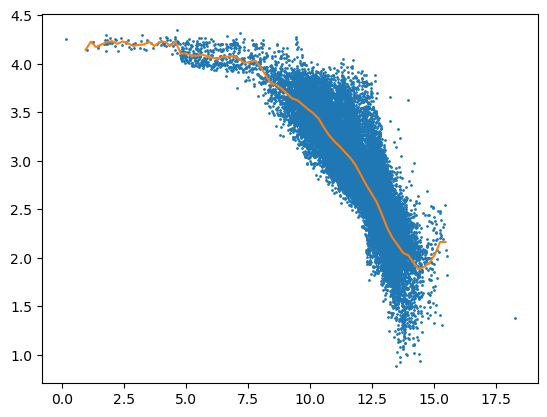

In [51]:
plt.scatter(amplitude[chroma==0], np.log10(1/(b_exp))[chroma==0], s=1)
plt.plot(amplitude_bin_centers, b_exp_mean, c="C1")
# plt.yscale("log")

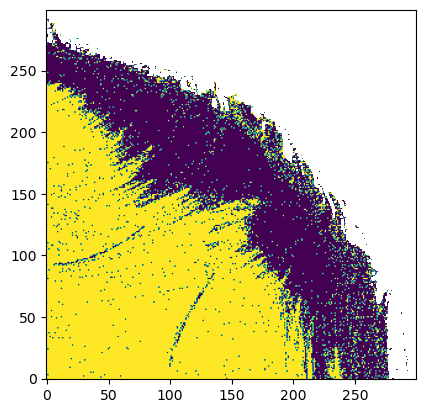

In [22]:
plt.imshow(chroma.reshape(300, 300), origin="lower")

/tmp/ipykernel_14516/278086403.py:1: RuntimeWarning: invalid value encountered in log10
  tmp = np.log10(b_power).copy()


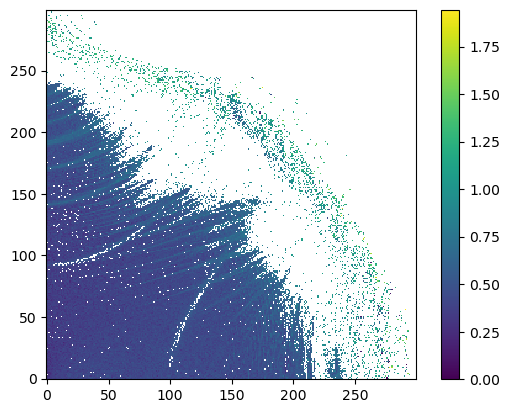

In [23]:
tmp = np.log10(b_power).copy()
tmp[chroma != 1] = np.nan
plt.imshow(tmp.reshape(300, 300), origin="lower", interpolation="nearest", vmin=0)
plt.colorbar()

/tmp/ipykernel_14516/3499048317.py:1: RuntimeWarning: invalid value encountered in log10
  tmp = np.log10(b_exp).copy()


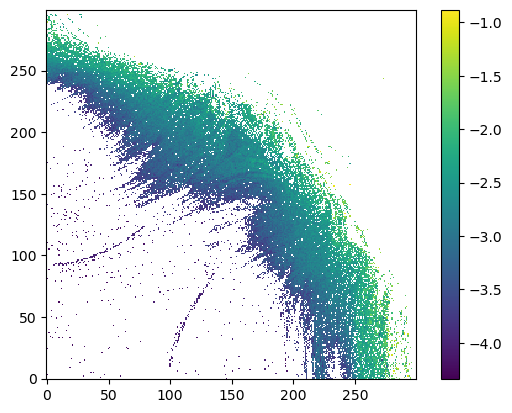

In [24]:
tmp = np.log10(b_exp).copy()
tmp[chroma != 0] = np.nan
plt.imshow(tmp.reshape(300, 300), origin="lower", interpolation="nearest")
plt.colorbar()

/tmp/ipykernel_14516/2876853992.py:1: RuntimeWarning: invalid value encountered in log10
  tmp = np.log10(b_exp).copy()


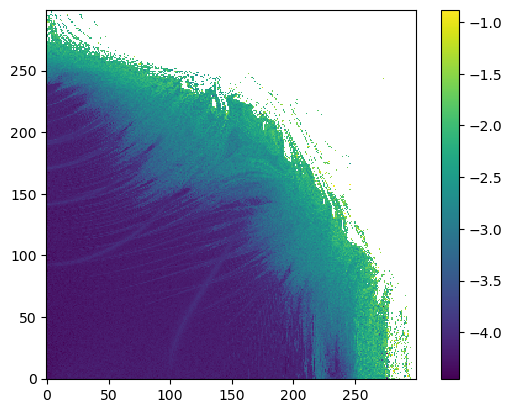

In [25]:
tmp = np.log10(b_exp).copy()
# tmp[chroma != 0] = np.nan
plt.imshow(tmp.reshape(300, 300), origin="lower", interpolation="nearest")
plt.colorbar()

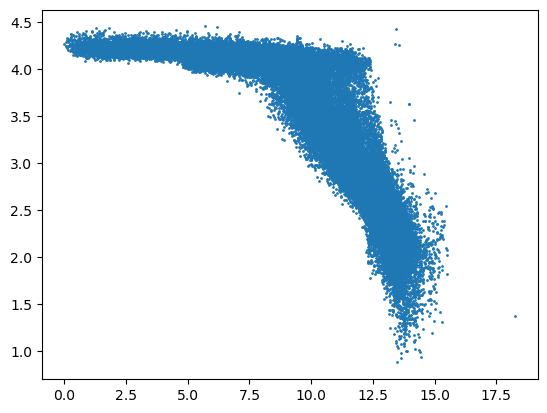

In [67]:
plt.scatter(amplitude, np.log10(1/(b_exp)), s=1)

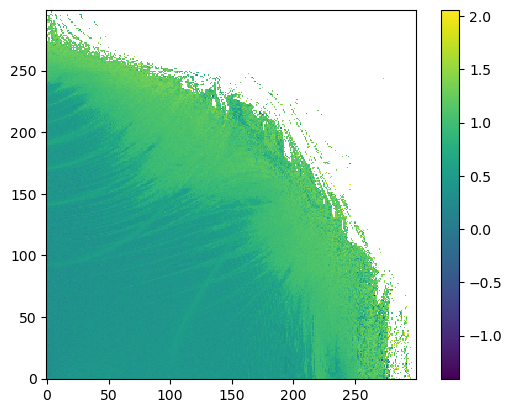

In [64]:
tmp = np.log10(b_power).copy()
# tmp[chroma != 0] = np.nan
plt.imshow(tmp.reshape(300, 300), origin="lower", interpolation="nearest")
plt.colorbar()

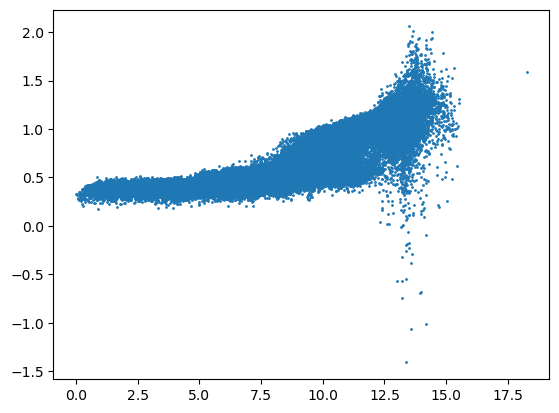

In [66]:
plt.scatter(amplitude, np.log10(b_power), s=1)